<a href="https://colab.research.google.com/github/RyanBadai/InceptionV3-Architecture/blob/main/X_Ray_Disease_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, load_model, Sequential
import tensorflow_hub as hub
import os
import cv2
from google.colab import drive
import zipfile
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Python Project/Pneumonia_Dataset.zip', 'r') as zip_ref:
  zip_ref.extractall("/content")

In [ ]:
sdir = r'/content/Pneumonia_Dataset'

filepaths = []
labels = []
classlist = os.listdir(sdir)

for klass in classlist:
  classpath = os.path.join(sdir, klass)
  if os.path.isdir(classpath):
    flist = os.listdir(classpath)
    for f in flist:
      fpath = os.path.join(classpath, f)
      filepaths.append(fpath)
      labels.append(klass)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

print(classlist)
print(df['labels'].value_counts())

['PNEUMONIA', 'NORMAL']
PNEUMONIA    3883
NORMAL       1349
Name: labels, dtype: int64


In [ ]:
#DATA AUGMENTATION
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255.,
                                  validation_split = 0.1)

In [ ]:
#TRAINING AND VALIDATION GENERATORS
train_generator = train_datagen.flow_from_directory(sdir,
                                                    target_size = (224,224),
                                                    batch_size = 64,
                                                    class_mode = 'binary',
                                                    subset='training')

validation_generator = test_datagen.flow_from_directory(sdir,
                                                  target_size = (224,224),
                                                  batch_size = 64,
                                                  class_mode = 'binary',
                                                  subset='validation')

Found 5232 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [ ]:
base_model = InceptionV3(input_shape = (224, 224, 3),
                         include_top = False,
                         weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history = model.fit(train_generator,
                    epochs = 5,
                    validation_data = validation_generator)

Epoch 1/5
82/82 [==============================] - 783s 9s/step - loss: 0.3572 - accuracy: 0.8322 - val_loss: 0.2314 - val_accuracy: 0.9215
Epoch 2/5
82/82 [==============================] - 772s 9s/step - loss: 0.2484 - accuracy: 0.8926 - val_loss: 0.2038 - val_accuracy: 0.9234
Epoch 3/5
82/82 [==============================] - 772s 9s/step - loss: 0.2352 - accuracy: 0.9018 - val_loss: 0.1824 - val_accuracy: 0.9387
Epoch 4/5
82/82 [==============================] - 769s 9s/step - loss: 0.2141 - accuracy: 0.9130 - val_loss: 0.1744 - val_accuracy: 0.9310
Epoch 5/5
82/82 [==============================] - 746s 9s/step - loss: 0.2111 - accuracy: 0.9148 - val_loss: 0.1738 - val_accuracy: 0.9368


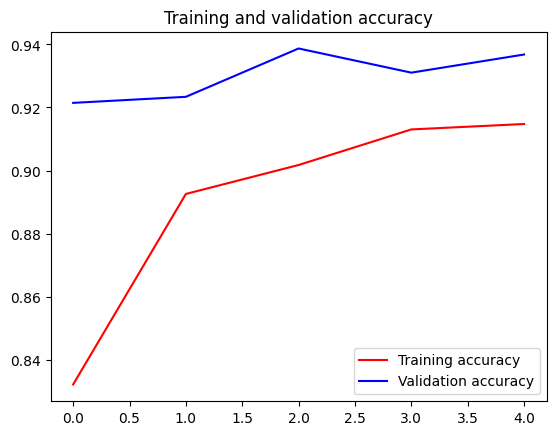

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
loss, accuracy = model.evaluate(validation_generator, verbose=0)
print(f"The Model Loss is {loss:.2f} and The Accuracy is {100*np.round(accuracy, 4)}%")

The Model Loss is 0.17 and The Accuracy is 93.67999999999999%


In [ ]:
pneumonia_recognition = '/content/drive/MyDrive/Python Project/model-pneumonia.h5'

model.save(pneumonia_recognition, save_format="h5")

In [ ]:
my_model = tf.keras.models.load_model(
    ('/content/drive/MyDrive/Python Project/model-pneumonia.h5'), custom_objects = {'kerasLayer':hub.KerasLayer}
)

1/1 [==============================] - 0s 140ms/step


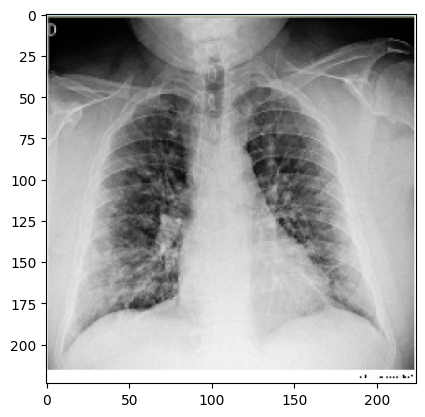

Predictions: Pneumonia
Probability: 0.9982938170433044


In [ ]:
image_path = '/content/gr1.jpeg'
image = load_img(image_path, target_size=(224,224))
image = img_to_array(image)
image = image / 255.

predictions = my_model.predict(np.expand_dims(image, axis=0))
probability = predictions[0][0]

threshold = 0.5
if probability >= threshold:
  result = "Pneumonia"
else:
  result = "Normal"

plt.imshow(image)
plt.show()
print(f"Predictions: {result}")
print(f"Probability: {probability}")